In [1]:
import numpy as np
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import os, codecs
import tensorflow as tf
from nltk.tokenize import RegexpTokenizer
import re
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import GlobalMaxPooling1D
import h5py
from keras.models import model_from_json
from keras.models import load_model

In [3]:
gloveFile = 'glove_6B_100d.txt'

vocab = set()
sentence_path = 'stanfordSentimentTreebank/SOStr.txt'
filtered_glove_path = os.path.join('stanfordSentimentTreebank', '/filtered_glove.txt')
# Download the full set of unlabeled sentences separated by '|'.
#sentence_path, = download_and_unzip(
#'http://nlp.stanford.edu/~socherr/', 'stanfordSentimentTreebank.zip',
#'stanfordSentimentTreebank/SOStr.txt')
with codecs.open(sentence_path, encoding='utf-8') as f:
    for line in f:
    # Drop the trailing newline and strip backslashes. Split into words.
        vocab.update(line.strip().replace('\\', '').split('|'))
nread = 0
nwrote = 0
with codecs.open(gloveFile, encoding='utf-8') as f:
    with codecs.open(filtered_glove_path, 'w', encoding='utf-8') as out:
        for line in f:
            nread += 1
            line = line.strip()
            if not line: continue
            if line.split(u' ', 1)[0] in vocab:
                out.write(line + '\n')
                nwrote += 1
print('read %s lines, wrote %s' % (nread, nwrote))


read 400000 lines, wrote 14941


In [4]:
print ("Loading Glove Model")
f = open(gloveFile,'r',encoding='utf-8')
model = {}
for line in f:
    try:
        splitLine = line.split()
        word = splitLine[0]
        embedding = [float(val) for val in splitLine[1:]]
        model[word] = embedding
    except:
        print (word)
        continue

print ("Done.",len(model)," words loaded!")

Loading Glove Model
Done. 400000  words loaded!


In [5]:
max_words = 1539 # max no of words in your data
batch_size = 2000 # batch size for training
EMBEDDING_DIM = 100 # size of the word embeddings
train_flag = True

In [6]:
first_run = False
load_all = True
if train_flag:

    if load_all == True:
        print('loading word embeddings from %s' % gloveFile)
        weight_vectors = []
        word_idx = {}
        with codecs.open(gloveFile, encoding='utf-8') as f:
            for line in f:
                word, vec = line.split(u' ', 1)
                word_idx[word] = len(weight_vectors)
                weight_vectors.append(np.array(vec.split(), dtype=np.float32))
        # Annoying implementation detail; '(' and ')' are replaced by '-LRB-' and
        # '-RRB-' respectively in the parse-trees.
        word_idx[u'-LRB-'] = word_idx.pop(u'(')
        word_idx[u'-RRB-'] = word_idx.pop(u')')
        # Random embedding vector for unknown words.
        weight_vectors.append(np.random.uniform(
            -0.05, 0.05, weight_vectors[0].shape).astype(np.float32))
        weight_matrix = np.stack(weight_vectors)

    else:
        print('loading word embeddings from %s' % filtered_glove_path)
        weight_vectors = []
        word_idx = {}
        with codecs.open(filtered_glove_path, encoding='utf-8') as f:
            for line in f:
                word, vec = line.split(u' ', 1)
                word_idx[word] = len(weight_vectors)
                weight_vectors.append(np.array(vec.split(), dtype=np.float32))
        # Annoying implementation detail; '(' and ')' are replaced by '-LRB-' and
        # '-RRB-' respectively in the parse-trees.
        word_idx[u'-LRB-'] = word_idx.pop(u'(')
        word_idx[u'-RRB-'] = word_idx.pop(u')')
        # Random embedding vector for unknown words.
        weight_vectors.append(np.random.uniform(
            -0.05, 0.05, weight_vectors[0].shape).astype(np.float32))
        weight_matrix = np.stack(weight_vectors)

loading word embeddings from glove_6B_100d.txt


In [7]:
modelRNN = Sequential()
modelRNN.add(Embedding(len(weight_matrix), EMBEDDING_DIM, weights=[weight_matrix], input_length=max_words, trainable=False))
modelRNN.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
modelRNN.add(Dense(512, activation='relu'))
modelRNN.add(Dropout(0.4))
modelRNN.add(Dense(10, activation='softmax'))
# try using different optimizers and different optimizer configs
modelRNN.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

modelRNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1539, 100)         40000100  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 40,371,310
Trainable params: 371,210
Non-trainable params: 40,000,100
_________________________________________________________________


In [8]:
df_amazon = pd.read_csv('Amazon_in.csv').drop('Unnamed: 0', axis = 1)
df_amazon

,user_id,ASIN,model_name,customer_name,Review_date,Reviews,Ratings
0,AEWOUFCYNMHAOVU27GLBTETUANJQ,B07SDPTP6Q,"OPPO A5 2020 (Dazzling White, 3GB RAM, 64GB St...",sanket yavalkar,23 September 2019,Brought this phone for my wife who is die hard...,5.0
1,AGGYOZ64YJTHOX5JJ3HIX45HTQ6Q,B07SDPTP6Q,"OPPO A5 2020 (Dazzling White, 3GB RAM, 64GB St...",Pj,22 September 2019,"Best option for exchange, I got it in 9k ,Revi...",5.0
2,AEQZJNT7OMU4AD4TAQDZASBEO4KQ,B07SDPTP6Q,"OPPO A5 2020 (Dazzling White, 3GB RAM, 64GB St...",Amit,24 September 2019,Good Phone With Exchange,5.0
3,AGPTVBSB2A66CPW6PAH73KW7KUZQ,B07SDPTP6Q,"OPPO A5 2020 (Dazzling White, 3GB RAM, 64GB St...",siddheshpatil,11 October 2019,Oppo makes very nice phone at this price range...,4.0
4,AH4UDKG5WUEJPD6KB5DWSQWCRQHQ,B07SDPTP6Q,"OPPO A5 2020 (Dazzling White, 3GB RAM, 64GB St...",Javed Shaikh,25 September 2019,Lowest speed ever seen in android and charger ...,1.0
...,...,...,...,...,...,...,...
989,AFQEUSIV2DTRFLKZVYPSZBEPSHKA,B07X8V6TJF,"Samsung Galaxy A51 (Black, 6GB RAM, 128GB Stor...",Sandeep,5 February 2020,I received a defective one and I'm just gettin...,1.0
990,AFPDMGK4PJXROQY4BARS7X6KO7WQ,B07X8V6TJF,"Samsung Galaxy A51 (Black, 6GB RAM, 128GB Stor...",Amazon Customer,16 February 2020,Read this before you make a buying decisionI m...,2.0
991,AE4B6WKEYELUGBG27T35BAUVKD2Q,B07X8V6TJF,"Samsung Galaxy A51 (Black, 6GB RAM, 128GB Stor...",Nilesh abhale,16 February 2020,+ve1. Great camera offcourse. Both rear and fr...,4.0
992,AEV75IBHJW5VVD4PBHZB3VKE3HNQ,B07X8V6TJF,"Samsung Galaxy A51 (Black, 6GB RAM, 128GB Stor...",Yogesh Kushwaha,5 February 2020,"Bought it for good camera, but its camera is v...",2.0


In [9]:
df_amazon['Reviews'][5]

'The first thing is slow charging of this mobile taking more than 3 hours for full charging.  My friend bought the same mobile but that was 4 gb ram and 64 gb rom in which he got hand free but my mobile was 3 gb ram and 64 rom in which they are not providing hand free. Why?'

In [10]:
from dateutil.parser import parse
dates = []
for date in df_amazon['Review_date']:
    dt = parse(date)
    dates.append(dt.date())
df_amazon['Review_date'] = pd.DataFrame(dates)

#Ratings:
####Here we have discrete values in ratings.
####As we can observe in count-graph that we have 5-star, 4-star and 1-star ratings are more than 100 respectively out of 994.
####Along with that we can use this ratings for comparision with prediction of review from modelRNN

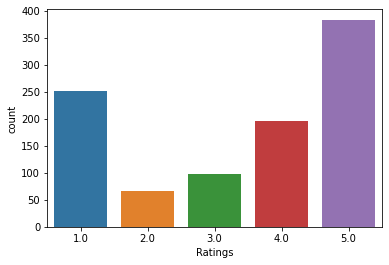

In [11]:
plt.figure()

sns.countplot(x = df_amazon['Ratings'], data = df_amazon)

In [12]:
df_amazon.groupby(['model_name']).sum().sort_values(by = ['Ratings'],ascending=False)[:10]

,Ratings
model_name,
"Samsung Guru FM Plus (SM-B110E/D, White)",68.0
"Samsung Guru Music 2 (SM-B310E, Blue)",68.0
"Samsung Guru Music 2 (SM-B310E, Black)",68.0
"Realme C15 (Power Blue, 4GB RAM, 64GB Storage)",58.0
"Redmi 9 Prime (Matte Black, 4GB RAM, 64GB Storage)",58.0
"Redmi Y3 (Prime Black, 3GB RAM, 32MP Selfie Camera, 32GB Storage, 4000mAH Battery)",56.0
"Redmi Note 9 (Scarlet Red, 4GB RAM, 64GB Storage)",50.0
"OPPO A52 (Stream White, 8GB RAM, 128GB Storage)",50.0
"Realme C11 (Rich Grey, 32 GB)",50.0


Here are the top 10 models which are rated high and have very positive response and high sells in the market.

In [13]:
total_words = 0
sequence_length = []
idx = 0
for index, row in df_amazon.iterrows():

    sentence = (row['Reviews'])
    sentence_words = sentence.split(' ')
    len_sentence_words = len(sentence_words)
    total_words = total_words + len_sentence_words

    # get the length of the sequence of each training data
    sequence_length.append(len_sentence_words)

    if idx == 0:
        max_seq_len = len_sentence_words


    if len_sentence_words > max_seq_len:
        max_seq_len = len_sentence_words
    idx = idx + 1

avg_words = total_words/index

# convert to numpy array
sequence_length_np = np.asarray(sequence_length)

In [28]:
weight_path = '/content/drive/My Drive/Colab Notebooks/best_modelRNN.hdf5'
modelRNN.load_weights(weight_path)
batchSize=len(df_amazon)
score_all  = []
for index, row in df_amazon.iterrows():

    data_sample = df_amazon['Reviews'][index]

    live_list = []
    live_list_np = np.zeros((56,batchSize))
    # split the sentence into its words and remove any punctuations.
    tokenizer = RegexpTokenizer(r'\w+')
    data_sample_list = tokenizer.tokenize(data_sample)

    labels = np.array(['1','2','3','4','5','6','7','8','9','10'], dtype = "int")
    #word_idx['I']
    # get index for the live stage
    data_index = np.array([word_idx[word.lower()] if word.lower() in word_idx else 0 for word in data_sample_list])
    data_index_np = np.array(data_index)

    # padded with zeros of length 56 i.e maximum length
    padded_array = np.zeros(1619) # use the def maxSeqLen(training_data) function to detemine the padding length for your data
    padded_array[:data_index_np.shape[0]] = data_index_np
    data_index_np_pad = padded_array.astype(int)
    live_list.append(data_index_np_pad)

    live_list_np = np.asarray(live_list)

    # get score from the model
    score = modelRNN.predict(live_list_np, batch_size=batchSize, verbose=0)
    #print (score)

    single_score = np.round(np.dot(score,labels)/20, decimals=2) # maximum of the array i.e single band
    score_all.append(single_score)

df_amazon['Sentiment_Score'] = pd.DataFrame(score_all)



In [33]:
df_amazon['Sentiment_Score'] = df_amazon['Sentiment_Score']*10

In [35]:
df_amazon.to_csv('Review_prediction.csv', index=len(df_amazon))